# Decision Tree Project
## Diabetes Prediction
MSalaverri

We want to predict whether a patient has diabetes based on diagnostic measurements, so healthcare providers can identify high-risk individuals more effectively and support early intervention strategies.

*Type of Problem:* **binary classification** problem using **Decision Tree.**

In [50]:
# IMPORT LIBRARIES

# Data manipulation & visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Modeling
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV

# Evaluation
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_auc_score
)

# Saving the model
import joblib

In [51]:
# LOADING ORIGINAL DATA
data = "https://breathecode.herokuapp.com/asset/internal-link?id=930&path=diabetes.csv"
df = pd.read_csv(data)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 1. Exploratory Data Analysis

In [52]:
#Dataset dimension
rows, column = df.shape
print("DATASET Dimension:")
print(f'{rows} rows and {column} columns')

DATASET Dimension:
768 rows and 9 columns


In [53]:
# Get information about range index, number of columns and labels, data types, and the number of cells in each column (non-null values)
print("DATASET General Info:")
df.info()

DATASET General Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [54]:
#List Missing values
all_missing_values = df.isnull().sum()
print("Null Values per Column:")
all_missing_values.reset_index()


Null Values per Column:


,index,0
0,Pregnancies,0
1,Glucose,0
2,BloodPressure,0
3,SkinThickness,0
4,Insulin,0
5,BMI,0
6,DiabetesPedigreeFunction,0
7,Age,0
8,Outcome,0


In [55]:
num_of_zeros = (df == 0).sum()
print("Count of Zeros per Column:")
num_of_zeros.sort_values(ascending=False).reset_index()

Count of Zeros per Column:


,index,0
0,Outcome,500
1,Insulin,374
2,SkinThickness,227
3,Pregnancies,111
4,BloodPressure,35
5,BMI,11
6,Glucose,5
7,DiabetesPedigreeFunction,0
8,Age,0


### Initial Inspection Summary

The dataset contains 768 rows and 9 columns, each row representing a patient with diagnostic measurements related to diabetes.

All columns are fully populated, with no missing values reported, but there are a large number of **Zeros** identified in *SkinThickness* and *Insulin* columns, as well as *BloodPressure* column that can't have 0 values. We'll need to handle or impute later on.

The dataset includes:

- 7 integer features (e.g., Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, Age, Outcome)
- 2 float features (BMI, DiabetesPedigreeFunction)

**Outcome** is the target variable: 0 means no diabetes, 1 means positive diagnosis.

## 2. Data Prep

### Only Missing Values

In [56]:
only_missing_values_columns = all_missing_values[all_missing_values > 0]
print("Only Missing Values Columns:")
only_missing_values_columns.reset_index()

Only Missing Values Columns:


,index,0


### Duplicates

In [57]:
#Looking for Duplicates
duplicates = df.duplicated()
sum_duplicates = duplicates.sum()

# VERIFICACION DE DUPLICADOS
print(f"Duplicated Rows: {sum_duplicates}")

Duplicated Rows: 0


No duplicates present

### Replace invalid Zeros with NaN
(Not a number)

In [ ]:
cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in cols_with_zeros:
    df[col] = df[col].replace(0, np.nan)

#Median Imputation
for col in cols_with_zeros:
    df.fillna({col: df[col].median()}, inplace=True)

In [59]:
#After Imputing
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,29.108073,140.671875,32.455208,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,8.791221,86.383060,6.875177,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## 3. Visualizations and Data Analysis

In [60]:
#Show Unique values per column name
n_uniques = df.nunique()
n_uniques.reset_index()

,index,0
0,Pregnancies,17
1,Glucose,135
2,BloodPressure,46
3,SkinThickness,50
4,Insulin,185
5,BMI,247
6,DiabetesPedigreeFunction,517
7,Age,52
8,Outcome,2


### Univariate Plots

#### Target Variable Distribution

*Note:* Target Variable is **Outcome**

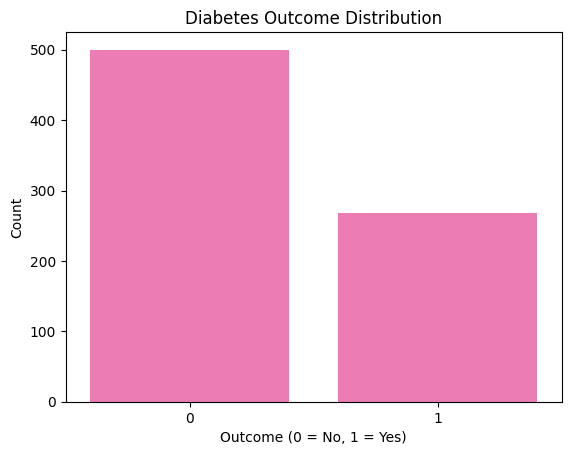

,Outcome,proportion
0,0,65.104167
1,1,34.895833


In [61]:
# Target (0 = no diabetes, 1 = diabetes).

sns.countplot(data=df, x='Outcome', color="hotpink")
plt.title("Diabetes Outcome Distribution")
plt.xlabel("Outcome (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

(df['Outcome'].value_counts(normalize=True)*100).reset_index()

#### Numeric Features Distribution

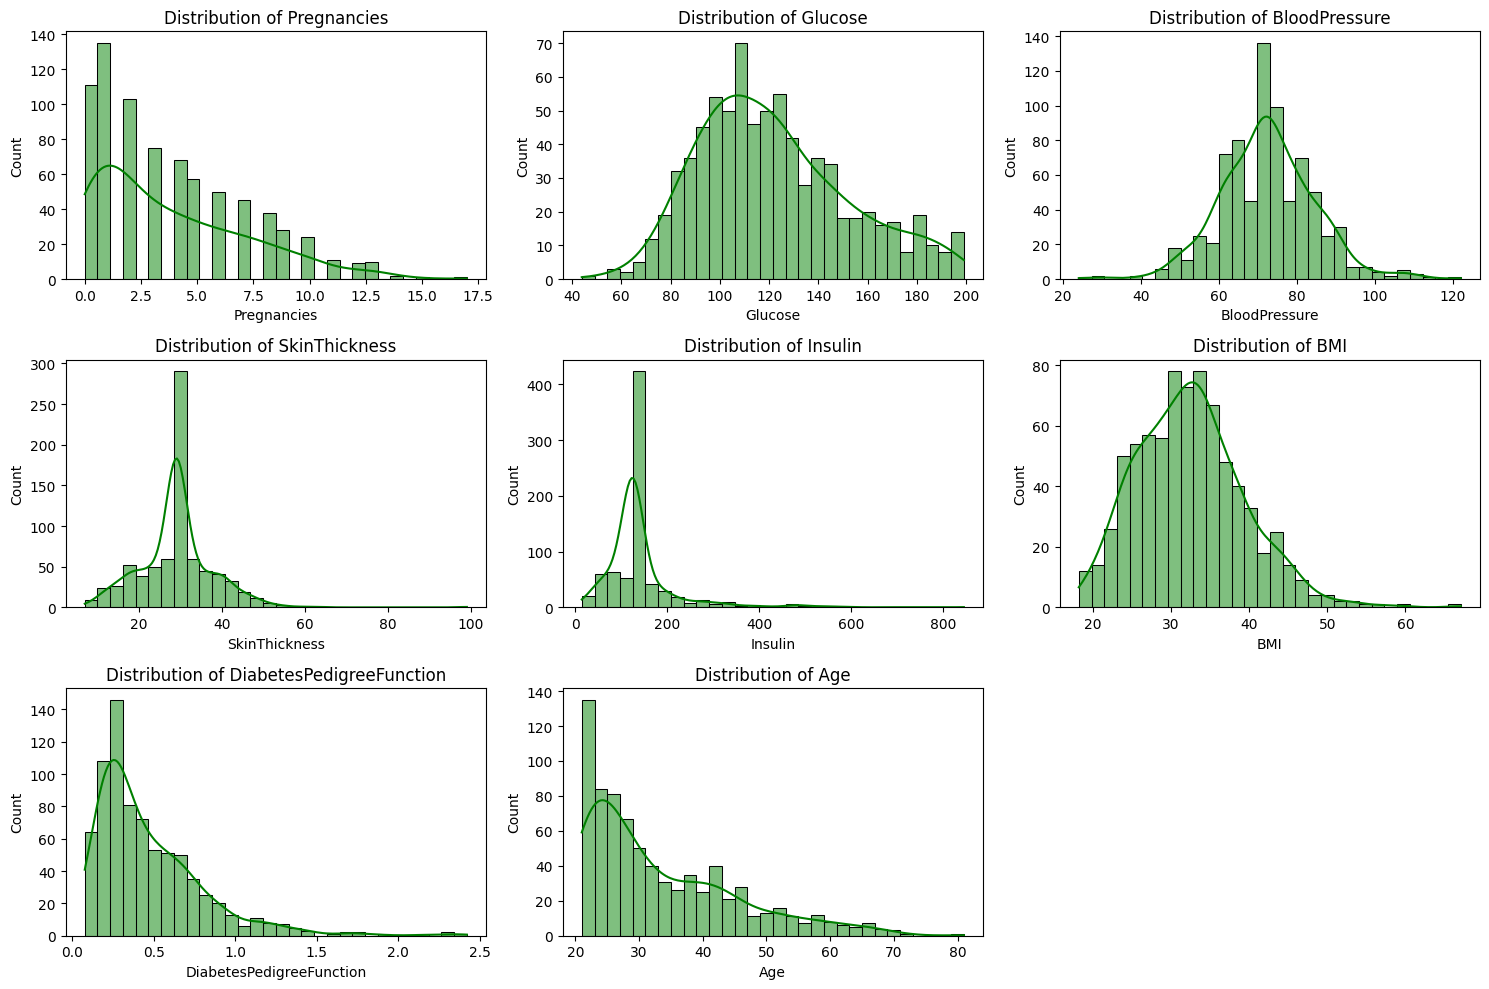

In [62]:
num_cols = df.select_dtypes(include=['int64', 'float64']).drop(columns='Outcome', axis=1).columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, bins=30, color="green")
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

### Bivariate Plots

#### Numeric Features vs Target Variable

*Note:* Target variable is **Outcome** (0 = no diabetes, 1 = diabetes)

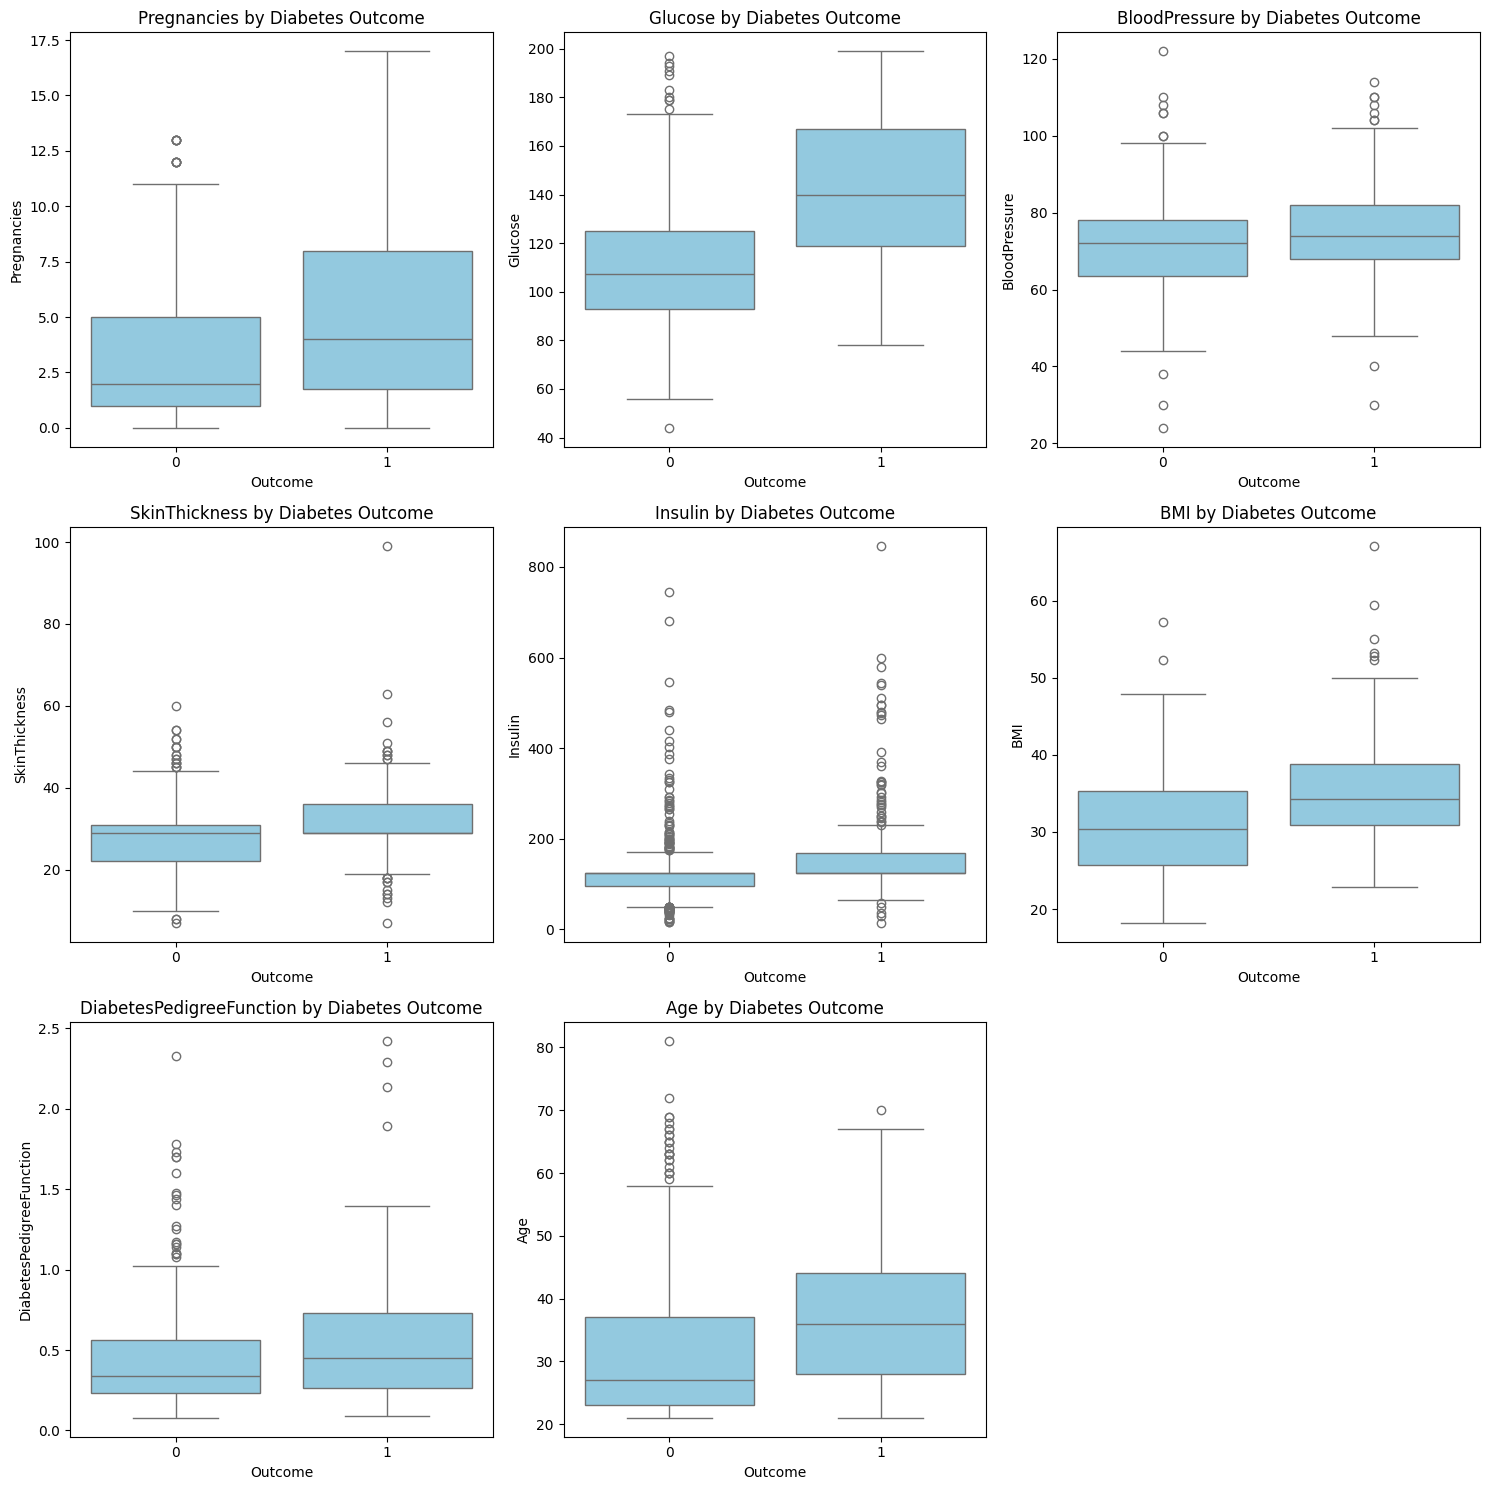

In [63]:
# Target (0 = no diabetes, 1 = diabetes)

plt.figure(figsize=(15, 15))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x="Outcome", y=col, data=df,color="skyblue")
    plt.title(f"{col} by Diabetes Outcome")
plt.tight_layout()
plt.show()


### Correlation Heatmap

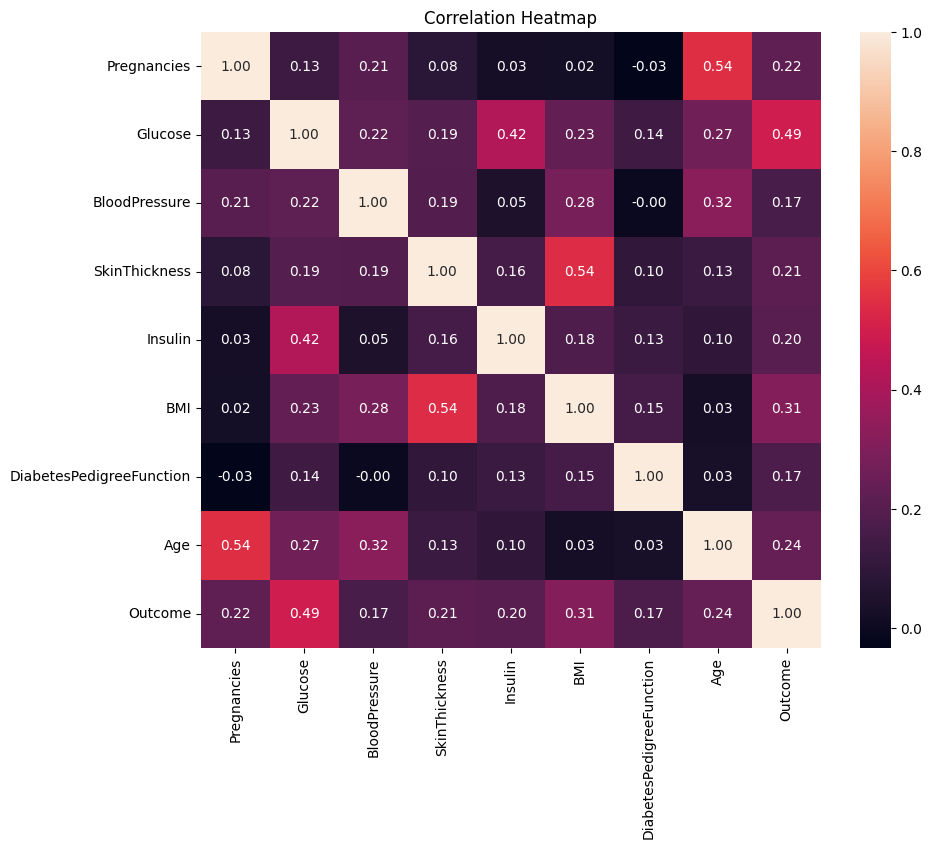

,index,Outcome
0,Outcome,1.000000
1,Glucose,0.492782
2,BMI,0.312038
3,Age,0.238356
4,Pregnancies,0.221898
5,SkinThickness,0.214873
6,Insulin,0.203790
7,DiabetesPedigreeFunction,0.173844
8,BloodPressure,0.165723


In [64]:
plt.figure(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

corr['Outcome'].sort_values(ascending=False).reset_index()

Glucose shows the strongest correlation with the diabetes outcome, followed by BMI, Age and Pregnancies.

These patterns make sense clinically and help guide feature importance.

## 4. Outlier Analysis

In [65]:
# generate a statistical summary of the numerical columns in a DataFrame
print("DATASET Statistical Summary:")
df.describe()

DATASET Statistical Summary:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,29.108073,140.671875,32.455208,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,8.791221,86.383060,6.875177,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [66]:
outliers = {}
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers[col] = df[(df[col] < lower) | (df[col] > upper)].shape[0]

# Outlier counts
pd.Series(outliers).sort_values(ascending=False).reset_index()


,index,0
0,Insulin,346
1,SkinThickness,87
2,DiabetesPedigreeFunction,29
3,BloodPressure,14
4,Age,9
5,BMI,8
6,Pregnancies,4
7,Glucose,0


BloodPressure and Insulin have the most extreme values.

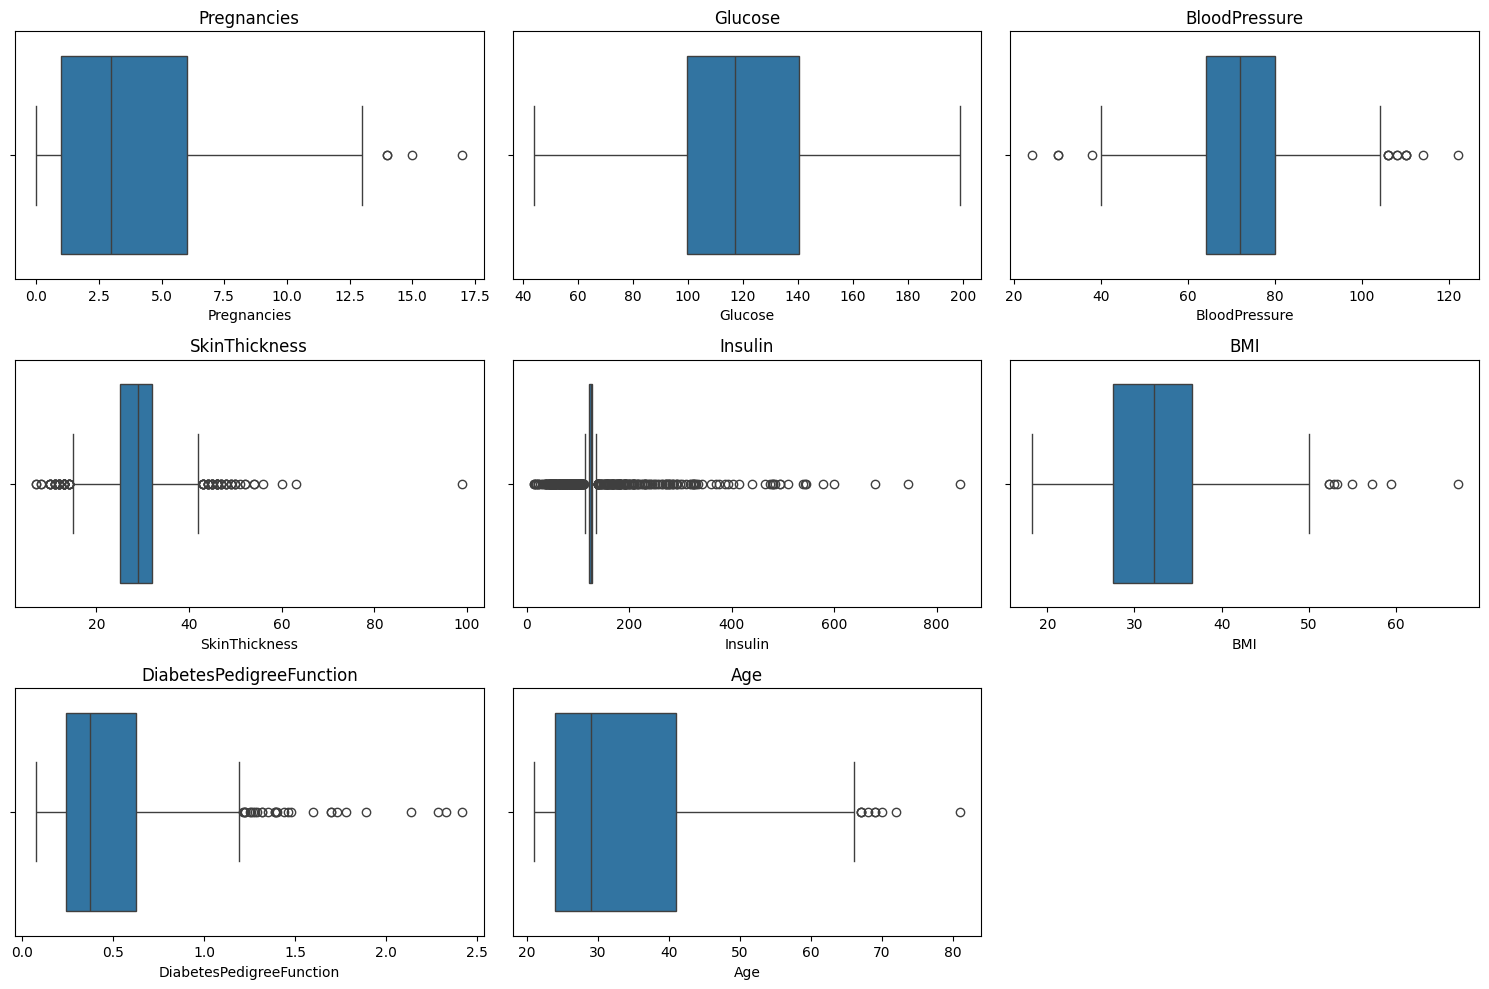

In [67]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()


## 5. Preprocessing

*Note:* **Encoding** is not necessary as all variables are numeric

### Train/Test

In [68]:
X = df.drop("Outcome", axis=1)
y = df["Outcome"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [69]:
print(f"Train: {X_train.shape}")

print(f"Test: {X_test.shape}")

Train: (614, 8)
Test: (154, 8)


## 6. Modeling

### Decision Tree Model

In [70]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


### Accuracy Analysis

In [71]:
y_pred = tree.predict(X_test)

print("=== Decision Tree ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("")
print("AUC Test:", roc_auc_score(y_test, y_pred))


=== Decision Tree ===
Accuracy: 0.7207792207792207

Confusion Matrix:
[[76 23]
 [20 35]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.77      0.78        99
           1       0.60      0.64      0.62        55

    accuracy                           0.72       154
   macro avg       0.70      0.70      0.70       154
weighted avg       0.72      0.72      0.72       154


AUC Test: 0.702020202020202


### Optimization

In [72]:
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 5, 10]
}
grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)


Best parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}


In [73]:
# Get best model from GridSearch
model_opt = grid.best_estimator_

In [74]:
# Predictions
y_pred_opt = model_opt.predict(X_test)
y_proba_opt = model_opt.predict_proba(X_test)[:, 1]

print("=== Optimized Decision Tree ===")
print("Accuracy:", accuracy_score(y_test, y_pred_opt))
print("")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_opt))
print("")
print("Classification Report:")
print(classification_report(y_test, y_pred_opt))
print("")
print("AUC Test:", roc_auc_score(y_test, y_proba_opt))

=== Optimized Decision Tree ===
Accuracy: 0.7727272727272727

Confusion Matrix:
[[85 14]
 [21 34]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83        99
           1       0.71      0.62      0.66        55

    accuracy                           0.77       154
   macro avg       0.76      0.74      0.74       154
weighted avg       0.77      0.77      0.77       154


AUC Test: 0.8053259871441689


### Optimized Tree Plot

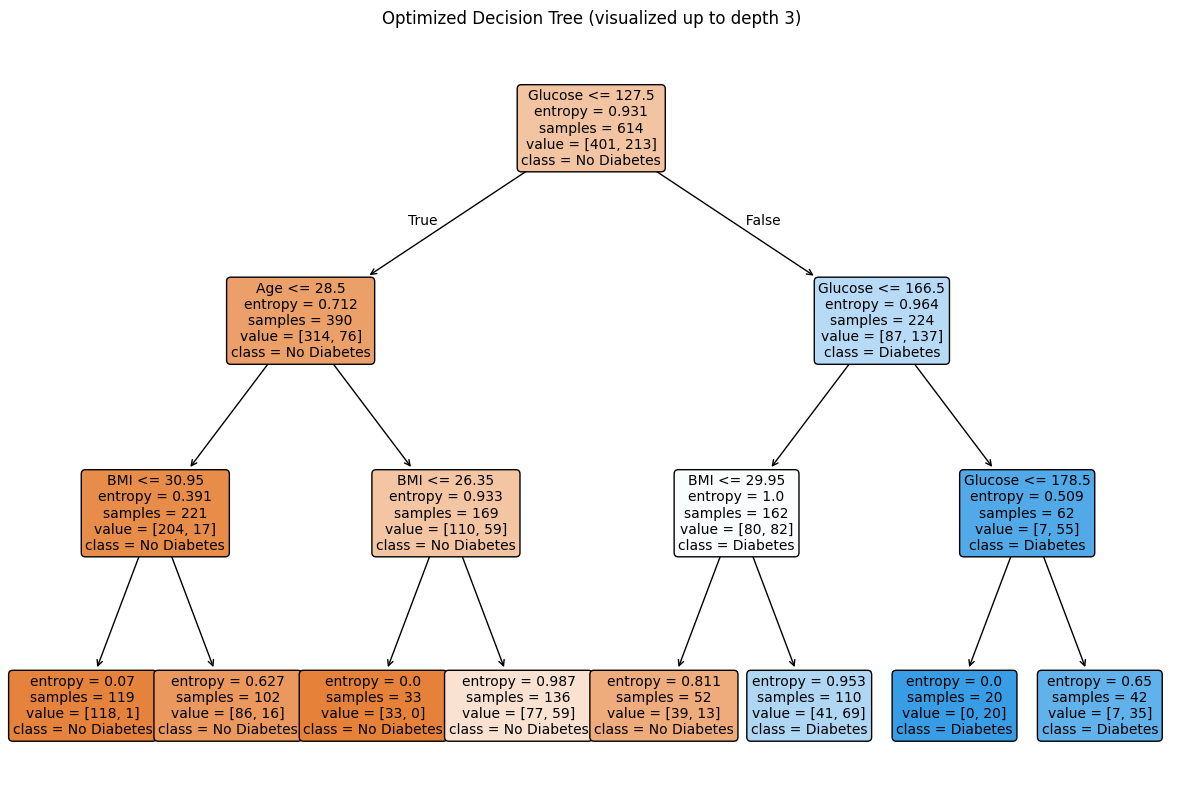

In [75]:
plt.figure(figsize=(15, 10))
plot_tree(
    model_opt,
    feature_names=X_train.columns,
    class_names=["No Diabetes", "Diabetes"],
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=3
)
plt.title("Optimized Decision Tree (visualized up to depth 3)")
plt.show()

## Final Conclusions
The optimized decision tree **improved** performance compared to the baseline. Accuracy reached around 77%, and the AUC was close to 0.80, which means the model can distinguish well between diabetic and non‑diabetic patients reasonably well.

Glucose came out as the most important variable, followed by BMI and insulin. This makes sense clinically.
- High glucose levels are a strong indicator of diabetes risk.

By limiting the depth of the tree, we avoided overfitting and kept the model interpretable. The optimization confirmed that tuning parameters like `max_depth` and `min_samples_split` helps balance accuracy and generalization.

**Conclusion:** Decision Trees give us a clear, interpretable baseline for diabetes prediction. The model is ready to use and can be extended with ensemble methods (Random Forest, Boosting) for further improvements.


In [76]:
joblib.dump(model_opt, "/workspaces/decision-tree-project-msalaverri/models/diabetes_decision_tree.pkl")
print("Optimized model saved to /models/diabetes_decision_tree.pkl")


Optimized model saved to /models/diabetes_decision_tree.pkl
